In [12]:
from edec.afterprocessing import import_labels,load_sql
from edec.preprocessing import compute_cell_dev_array, compute_soc_deviation
import edec.afterprocessing as ap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import gc
%matplotlib inline

In [13]:
def get_SOC_failed_cells(array):
    """Function what return will which cells is failing"""
    arr = np.array(compute_cell_dev_array(array))
    threshhold = 0.09

    failed_SOC_cells = np.where(arr >0.09)[0]
    return failed_SOC_cells

def get_Volt_failed_cells(array):
    """Function what return will which cells is failing"""
    arr = np.array(compute_cell_dev_array(array))
    threshhold = 0.09

    failed_SOC_cells = np.where(arr >0.09)[0]
    return failed_SOC_cells


def filter_failed_cells(unfiltered_array,failed_cells):
    """Create a filtered list based on failed cells"""
    filtered_array = [unfiltered_array[i] for i in failed_cells]
    return filtered_array

def normalize(x):
    median = np.median(x)
    return (x - median)/median # Can also use mean (Difference?)

def delete_rows_after_lastfail(df_tin):
    max_index = df_tin[df_tin["Fail"] == 1].index.values
    last_idx = max_index[-1]
    df_tin = df_tin[:last_idx + 1]
    return df_tin
    
def get_cell_fails_array(df_tin):
    """Return a pandas series with Failed Cell Soc value for eached failed cell (cell_fails)
       And a list with index numbers of failed cells failed_cells     
    """
    df_failed_cells = df_tin[df_tin["Failed cell SOC"].str.len() != 0]
    fail_dates = df_failed_cells["timestamp"].to_list()
    Un = np.array(df_failed_cells["Failed cell SOC"]) # Array with all arrays of failed cells (array[array[1,2], array[1,2])
    failed_cells = []
    for i in Un:
        failed_cells.extend(list(i))
    failed_cells = list(set(failed_cells))
    failed_cells.sort()

    cell_fails = df_tin["Sorted_SOC_deviation"].apply(lambda i:filter_failed_cells(i,failed_cells))
    return cell_fails, failed_cells, fail_dates

def generate_cell_df(df_tin, failed_cells, method): ### Lägger till method  method="Sorted_SOC_deviation"
    """Generate a datafram with each cell or fail as columns"""
    
    #df_clean = pd.DataFrame([x for x in df_tin["Sorted_SOC_deviation"]])
    df_clean = pd.DataFrame([x for x in df_tin[method]])
    df_clean.columns = ['x_cell_{}'.format(x) for x in range(108)]

    for i in range(len(df_clean.columns)):
        if i in failed_cells:
            df_clean.rename(columns={df_clean.columns[i]:df_clean.columns[i].replace("x","Fail")},inplace=True)
        else:
            df_clean.rename(columns={df_clean.columns[i]:df_clean.columns[i].replace("x","Healthy")},inplace=True)
    
    df_clean.insert(0, "timestamp",df_tin["timestamp"])
    df_clean.set_index('timestamp',inplace=True)
    return df_clean

def get_cell_status(col_name):
    """ 
    Get the status 0/1 for each column in df_clean 
    """
    
    if col_name.split("_")[0] == 'Healthy':
        cell_fail = 0
    else: 
        cell_fail = 1
    return cell_fail

def healty_column_names(df_clean_last_SOC):
    # df3
    """
    Retun a list of healty column names
    (function is used for dropping healty cells to get a df with failed cells only)

    """
    col_names = []
    for col_name in df_clean_last_SOC.columns:
        cell_fail = get_cell_status(col_name)
        col_names.append(cell_fail)
    arr = np.where(np.array(col_names) !=1)[0]
    arr = list(arr)
    healthy_drops = [df_clean_last_SOC.columns[i] for i in arr]
    return healthy_drops


In [3]:
claimlist1 = ('a82ab98a64dab23bf4aa1bbee6bcf2f8b4f23a5de74edfe79a7ceff3e2dd850c',
       '046994de6e1e013c2d4162502e19eb7b42a764c83d6d1213bf6d6bcd44b7ed49',
       '74f89d7e6a68aa5de245f7ea839d0db10815d44502a2112e192010ee2d60c629',
       '277f8f8aec3534be8448220ea3b99127dd8fc2bddb9140c25e97d8bf46dd1d1e',
       '0144e57f668058ebb3703b1fcdadd896fdb038f2449b729e5886ae7d51fe0725',
       'eb830e4babf5934638657124ac896b2b3ecb681011260e66ad48f746dd03a901',
       'd095e3278854e2999cd6aa3cf423457179d50c47de33ff07e0fed6aaa81099e3',
       '77cb437f82a3b29b021b16e028614ee48068d84a9dfa8e71762ff8ac1f92bf14',
       '265873d8277b1ff05fdce33bab3a292fcdf4be4df0103d388a82cb0ba5700108',
       '9728f656bdcff7aef9888478ebc2e7835936c52ba3b5e7bb6f69a554cb88af09',
       'aa595bd086d8454d1b8c50d8ca48b004773acf5199f7a12d53a1e3c3587c1096',
       '16b533e2d5cbfb3fa66357503bd773ebdfea557537f02bf088c067210798bbc1',
       '102ee98b695abed670870d66ed9d8e9a78c7a4343f480a0e5bffc51af03076d7',
       '460ed755a597b2b685a7ab5e02ecd5c073aff7735a18f82633ba8006da2d7f5c',
       '36ea9106b280d52434942ab822e91e1a602bd8517b1499ab32c0e48d368f046e')

claimlist2= ('31d976cc0260161219fab2d85bfc20f2fd837abf11de693f0cdd262adebf705e',
'f890289159601c39eb483a94ebd34572d984762e4a765379a9823786a509677d',
'a82ab98a64dab23bf4aa1bbee6bcf2f8b4f23a5de74edfe79a7ceff3e2dd850c',
'046994de6e1e013c2d4162502e19eb7b42a764c83d6d1213bf6d6bcd44b7ed49',
'74f89d7e6a68aa5de245f7ea839d0db10815d44502a2112e192010ee2d60c629',
'7b8faa5438d7b36014373f096699ded545b194251a18007f3e1057b4597313e6',
'a6501d842845fe9b0803a8bf60e4dbcfe046a0f942e555d6e96c0db5a174a62a',
'633a2abf73c98e94c8c0954460507493778cff82fd0a5f539ff69ad9533f7fba',
'277f8f8aec3534be8448220ea3b99127dd8fc2bddb9140c25e97d8bf46dd1d1e',
'4d4d94dc073cadacefdc6250dd908c72bc1fe608bbd218fedf33cb02666f97ea',
'0144e57f668058ebb3703b1fcdadd896fdb038f2449b729e5886ae7d51fe0725',
'6a62c3d7e59fa3b6187eaca7190f20b5605728c579d3be3f6ada7a54fbe81cf6',
'a15737e85bc90ecb7e5e66b0b9d475a0608170c402c9d1756f28ef9143c01926',
'e440013ce08950d076737627e6c6dae2f53519e8e1ee4f64c314253dbaad3037',
'6061cd087c349f1d6adf072747a4b39c9720a77f86f914c4255d17e1aff551f0',
'9408b2d98c96005834412dda693a722f0f9c29ad303807b79b9868d8d1bbef4f',
'c2cca219bd63802fb333ca703ca74c3853742e55b233ca4332e868d62ed2a879',
'eb830e4babf5934638657124ac896b2b3ecb681011260e66ad48f746dd03a901',
'0256f544c5567ba04cfef1e62811a9c271523fa9f08398bdeb9c64f24f71fd53',
'84601d08eeaaf6b102bf66bbf59e5fe8d4f8fe0db2c77beef2f549139f876eb0',
'857ecf7b4632ecef0721a50ad3cdcc83ea86b99cb82f669b471fa3089e82e650',
'f8b56894314d9c7036eaf3fe0c33c9c05f69f5dce9ffb20ff42a5319ea3759e6',
'153040d2718a614a7ea1ce5ead13bd0e268350510dbea737ba229a804e84a66e',
'9fe1599ad27eee0fefaeb07324c2bb7d848aa4082e16365fa47977283b32356f',
'36a48fe41b39d708172a7e612a2aa76ef3ef389dfbea33ac03708c75a936c330',
'7bf5442612cf01207dff4c08e572cce3a12c91392d6dae3a69658d16ed503711',
'c783899b9de46ee485a32193ceec81445266f066e87ade30334e09c1530979cd',
'27340543bf52003098d299d55600d84ed6f205721797e37a326791e8eff12792',
'f2ac9cab6f187c96c235c491cae16d575413c46e5b1da757cb146aee98f3cfa3',
'6d13f132b6606fddeb65157dce12ce970bde79214a6eb3def83dceca5da7def1',
'6d96f2f0eee2bf11aaece23282385195e6804ff8905897601876646acf8b792e',
'd095e3278854e2999cd6aa3cf423457179d50c47de33ff07e0fed6aaa81099e3',
'f5046c8ef2ab954b50feb7e69a81ff16c9252af55353090d23a3e134c77d7358',
'64dc7285984d9975f3b7c2716cb4c23fe4e861b19a04ce11ae3eaaeabb9fc042',
'eb1e60b78844be97100f496db710e51b034dd43de4b432192a7dbb86e5d95a0c',
'77cb437f82a3b29b021b16e028614ee48068d84a9dfa8e71762ff8ac1f92bf14',
'94e1f3623bf8e8e3687c581904e4f9452a5f2cc9d365272f055492c143ea64af',
'265873d8277b1ff05fdce33bab3a292fcdf4be4df0103d388a82cb0ba5700108',
'474735971b69e240c0ee4f678ace6426e96fdc2f408b7c09b43c93788fd81f46',
'9728f656bdcff7aef9888478ebc2e7835936c52ba3b5e7bb6f69a554cb88af09',
'e01430115d785d6c42fcd441162c98706069af23a0c40f41991e3d0d9502772e',
'1c7a05ee9199297e46c8ee9110641571576972dc2560bb10120e587ba40a40f3',
'46ccfe11b46f362a00a642c830aa6f8b4fe453530a9214e6b1a4666a8ebdda3d',
'901a724bd6caf9a1fa7f31ef044d85970fe95139df987ebd5cdafffd34773064',
'9e396f2958d7daed0826aac8f88e1405f75c67fd4620d3ab6b6e2bb01e5bb8d9',
'f3f0bc5bf9d36f23f76f7dc59372621bac253b5d8a7360955e77b010ca36e581',
'39fa208d5fa891c35cc722ebf324954a8f6d53ae46b74aea3932823bc501d9ed',
'3fd6ccad3908b9538521b856736d685d8c36be99a9a73faa7e611cc6eff1dff0',
'aa595bd086d8454d1b8c50d8ca48b004773acf5199f7a12d53a1e3c3587c1096',
'842385086edab721a4c2274411221b70b180050c501906ab2e39d091b88bc215',
'16b533e2d5cbfb3fa66357503bd773ebdfea557537f02bf088c067210798bbc1',
'e7586f83d7fcd91d932c54017ddcf7357984719082a724584691c797386072b1',
'31800fdec6ac63b9ea1cb4b540263b872ff807c10bde656c15e2b98f5e560a88',
'cdd94854e426fc078baf9048195ea744cf04e228cba24f1c55d660ba85622382',
'102ee98b695abed670870d66ed9d8e9a78c7a4343f480a0e5bffc51af03076d7',
'460ed755a597b2b685a7ab5e02ecd5c073aff7735a18f82633ba8006da2d7f5c',
'36ea9106b280d52434942ab822e91e1a602bd8517b1499ab32c0e48d368f046e',
'4ae85dc538354fa8ffdbc21d51ad6955312206fd2fb62d28dbece5a31dde9d69')

query = f"SELECT main_table.tin_an, [timestamp], [Sorted_SOC],[Sorted_Voltage],\
            cell_fail.Fail FROM main_table \
            INNER JOIN cell_fail \
            ON main_table.rid = cell_fail.rid \
            WHERE [tin_an] in {claimlist1}"

df = ap.load_sql(query, db="df.db")
df.sort_values(by=["timestamp"], ascending=True,inplace=True)
df.head()

,tin_an,timestamp,Sorted_SOC,Sorted_Voltage,Fail
3177,74f89d7e6a68aa5de245f7ea839d0db10815d44502a211...,2020-11-11 15:23:52,"[46.43, 46.43, 46.25, 46.45, 46.54, 46.48, 46....","[3.6007, 3.6029, 3.6013, 3.601, 3.601, 3.6017,...",0
2780,74f89d7e6a68aa5de245f7ea839d0db10815d44502a211...,2020-11-12 16:11:28,"[63.92, 63.89, 63.68, 63.91, 63.99, 63.94, 64....","[3.8347, 3.8344, 3.832, 3.8343, 3.8351, 3.8345...",0
2485,74f89d7e6a68aa5de245f7ea839d0db10815d44502a211...,2020-11-13 18:10:27,"[65.96, 65.93, 65.72, 65.95, 66.02, 65.97, 66....","[3.8584, 3.8588, 3.8566, 3.8586, 3.8591, 3.859...",0
4398,36ea9106b280d52434942ab822e91e1a602bd8517b1499...,2020-11-14 12:36:41,"[76.15, 76.37, 76.31, 76.39, 76.01, 76.12, 75....","[3.9571, 3.9596, 3.9591, 3.9597, 3.9557, 3.957...",0
3738,36ea9106b280d52434942ab822e91e1a602bd8517b1499...,2020-11-15 14:53:31,"[62.33, 62.53, 62.49, 62.56, 62.22, 62.31, 62....","[3.8347, 3.8354, 3.8346, 3.836, 3.8338, 3.8331...",0


In [14]:
cars_to_show = 2
#tin_exclude_list = ('e440013ce08950d076737627e6c6dae2f53519e8e1ee4f64c314253dbaad3037','6a62c3d7e59fa3b6187eaca7190f20b5605728c579d3be3f6ada7a54fbe81cf6')
df = import_labels(label=1, db="df.db", n_random=cars_to_show, tin_exclude_list=False)
df.head(2)

2 Unique cars with label 1 has been imported with 615 subsamples


,tin_an,timestamp,Sorted_SOC,Sorted_Voltage,Fail
68,6a62c3d7e59fa3b6187eaca7190f20b5605728c579d3be...,2020-12-16 07:31:02,"[81.5, 81.31, 81.77, 81.63, 81.24, 81.03, 81.4...","[4.0116, 4.0096, 4.0147, 4.0129, 4.0084, 4.006...",0
544,6a62c3d7e59fa3b6187eaca7190f20b5605728c579d3be...,2020-12-17 08:16:19,"[78.0, 77.8, 78.22, 78.12, 77.77, 77.55, 77.91...","[3.9772, 3.9758, 3.9801, 3.9787, 3.9744, 3.972...",0


In [ ]:
df_clean_last_SOC, df_tin_last, cars = plot_cells(df, show_legend=False, show_cells="all", method="Sorted_SOC_deviation")
#cars

In [4]:
##### Fungerande kod
def plot_cells(df, show_legend=False, show_cells=1,method="Sorted_SOC_deviation"):
    """
    Function takes in df
    show_legend: True / False
    show_cells: [1: only fail] [0: Only Healthy] ["all": Both healthy and fail]
    Method: ["Sorted_SOC_deviation"] ["Sorted_Voltage_deviation"]
    """

    plot_params ={"linewidth":{
                                0: 0.2,
                                1: 1.5,
                                },
                    "linestyle":{0: "solid", #(0,(3,5,1,5)), # dashdotted
                                1: "solid",
                                }
                }


    # Annotate with Failed cell SOC and Voltage
    df["Failed cell SOC"] = df["Sorted_SOC"].apply(get_SOC_failed_cells)
    df["Failed cell Voltage"] = df["Sorted_Voltage"].apply(get_SOC_failed_cells)
    
    #global cars
    cars = df["tin_an"].unique()
    

    for car in range(len(cars)):
        
        # Get List of individual Tins
        df_tin = df[df["tin_an"] == cars[car]]
        df_tin = df_tin.reset_index()

        # Get type of fail (0 or 1)
        fail_type = df_tin["Fail"].unique().max()

        # Apply normalization (deviation)
        df_tin["Sorted_SOC_deviation"] = df_tin["Sorted_SOC"].apply(normalize)
        df_tin["Sorted_Voltage_deviation"] = df_tin["Sorted_Voltage"].apply(normalize)

        fail_dates = []
        failed_cells = []
        if fail_type == 1:
            df_tin = delete_rows_after_lastfail(df_tin)

            cell_fails, failed_cells, fail_dates = get_cell_fails_array(df_tin)
        
        # Generate dataframe with cells as columns
        df_clean = generate_cell_df(df_tin, failed_cells, method)

        # Plot cells
        fig, ax = plt.subplots(1,2,figsize=(25,4),gridspec_kw={'width_ratios': [3, 1]})  

        for col_name in df_clean.columns:
            cell_fail = get_cell_status(col_name)
            if show_cells == cell_fail:
                ax[0].plot(df_clean[col_name], label=col_name, marker='.', linewidth=plot_params["linewidth"][cell_fail], linestyle=plot_params["linestyle"][cell_fail])
                
            if show_cells == "all":
                ax[0].plot(df_clean[col_name], label=col_name, marker='.', linewidth=plot_params["linewidth"][cell_fail], linestyle=plot_params["linestyle"][cell_fail])

        if (show_cells == 1) or (show_cells == "all"):
            ymin, ymax = ax[0].get_ylim()
            ax[0].vlines(x=fail_dates, ymin=ymin, ymax=ymax, color='r',linewidth=0.8, linestyle=(0,(5,10)))
            
        if show_legend:
            ax[0].legend()
            if show_legend:
                ax[0].legend(bbox_to_anchor=(-0.2, 0.0), loc='lower right')
        # Plot scatterplot of cell mean
        color = [get_cell_status(i) for i in df_clean.columns.tolist()]
        #color = ax[0].get_color()
        x = np.linspace(0,107,108)
        y =  df_clean.mean()
        for i in range(len(x)):
            ax[1].scatter(x[i], y[i])
        
        #ax[1].legend()
        ax[1].set_title('Cell dev')
        ax[1].set_ylabel("Cell Percent Deviation")
        ax[1].set_xlabel("Cell Number")

        ax[0].set_title(f'Tin number {cars[car]}')
        ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=20))
        plt.xticks(rotation=45, ha="left")
        #ax.xticks(rotation=45, ha="left")
        #ax[0].set_xticklabels(ax[0].get_xticks(), rotation = 45)

        #ax[0].set_ylim([0, 5])
        ax[1].set_ylim([-0.14, 0.14])
        ax[0].grid()
        ax[0].set_title(f'Tin number {cars[car]}')
        ax[0].set_ylabel("Cell Percent Deviation")
        plt.show()
        plt.close()
        gc.collect() 
    return df_clean, df_tin, cars
    

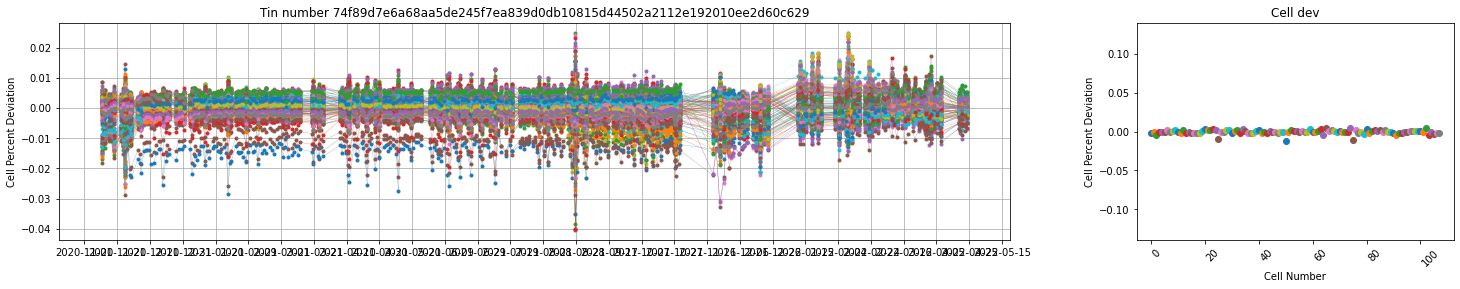

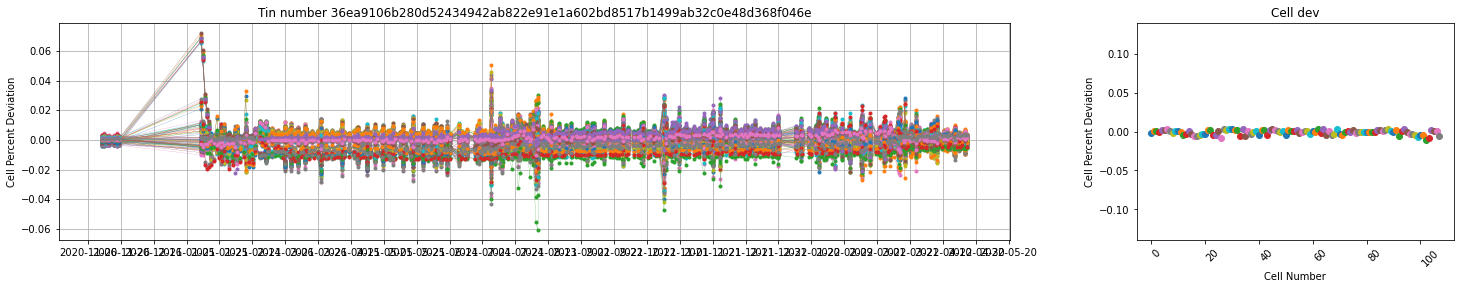

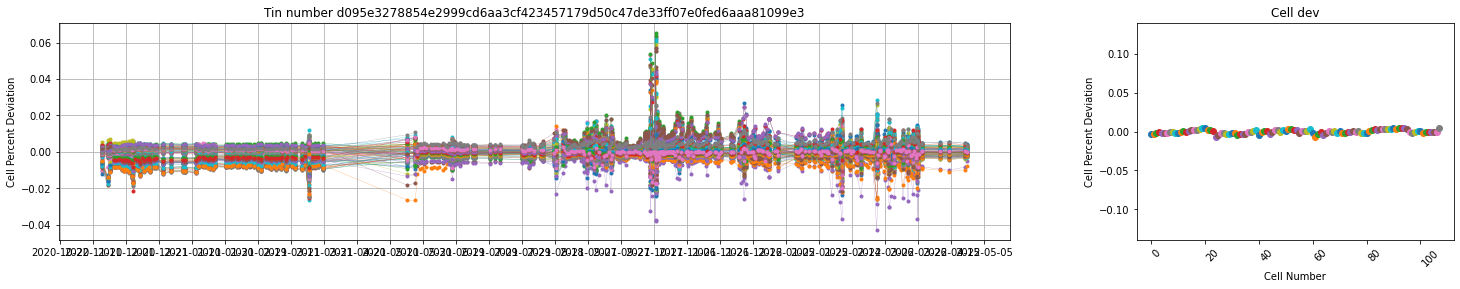

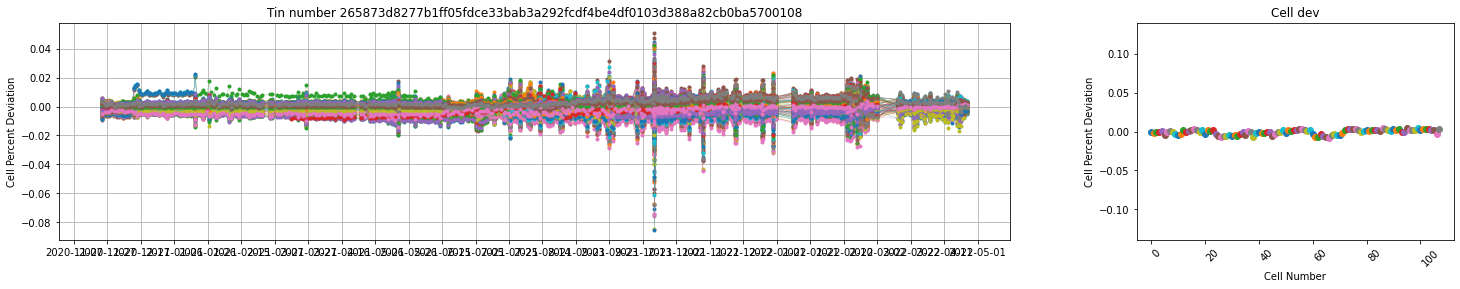

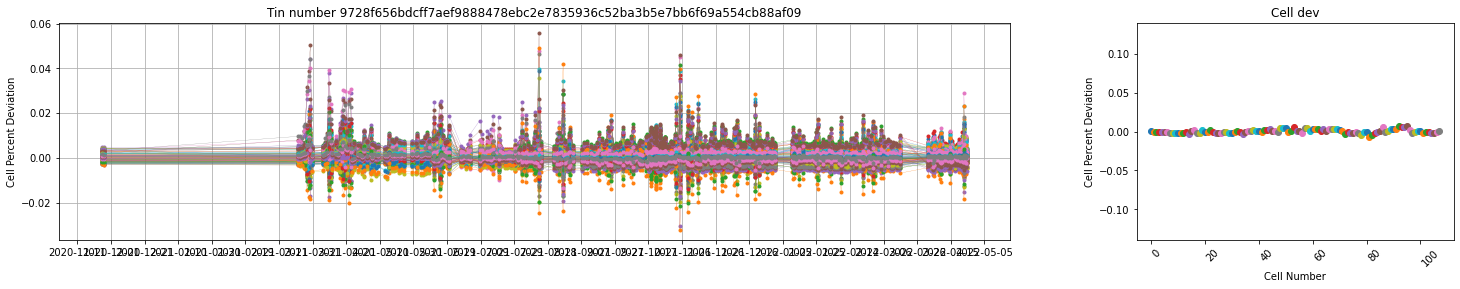

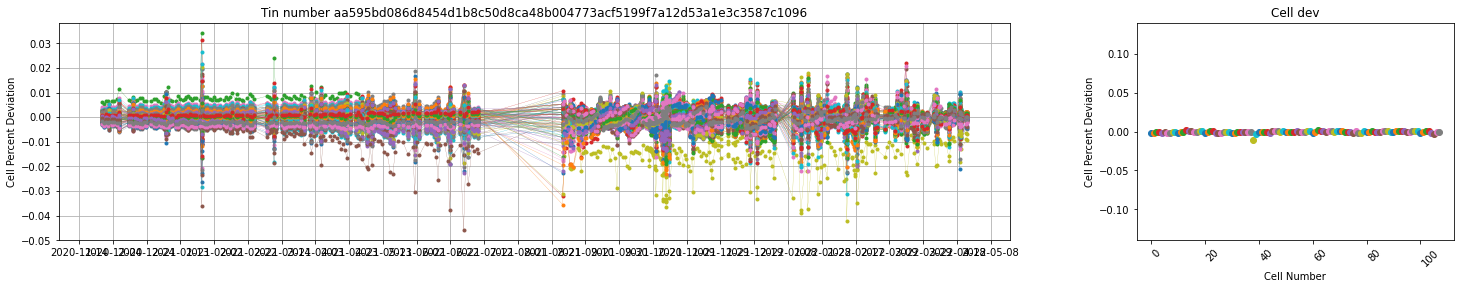

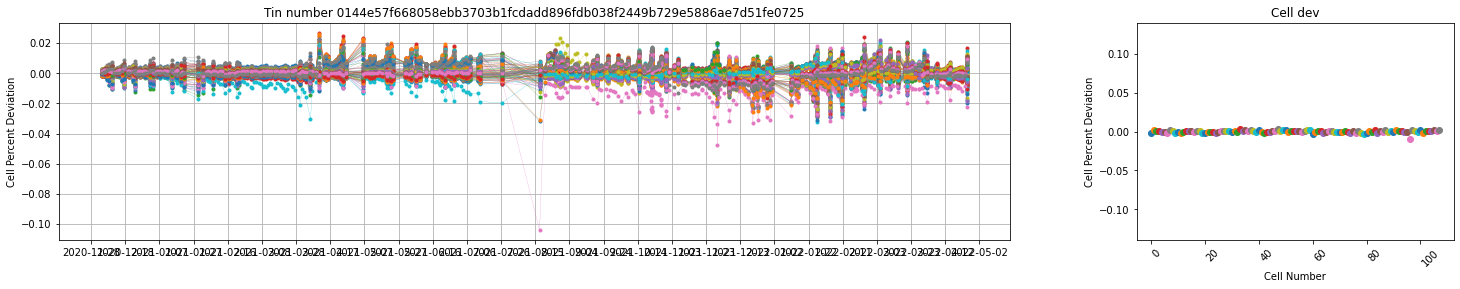

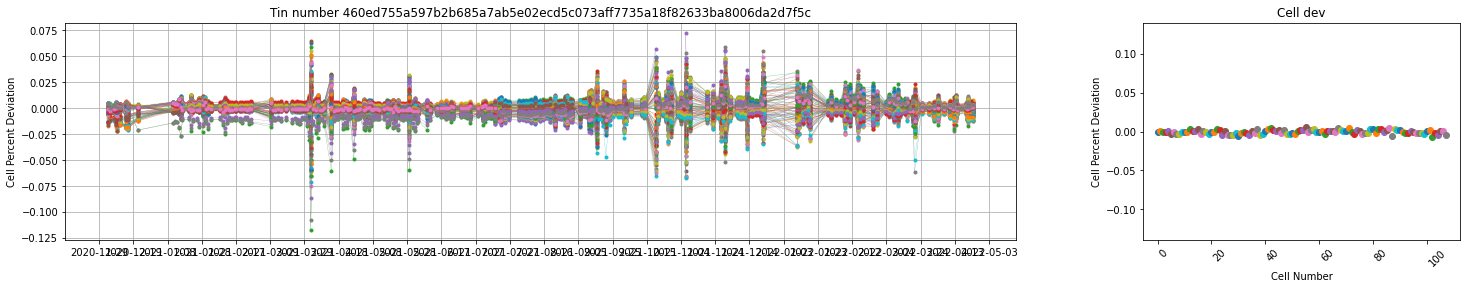

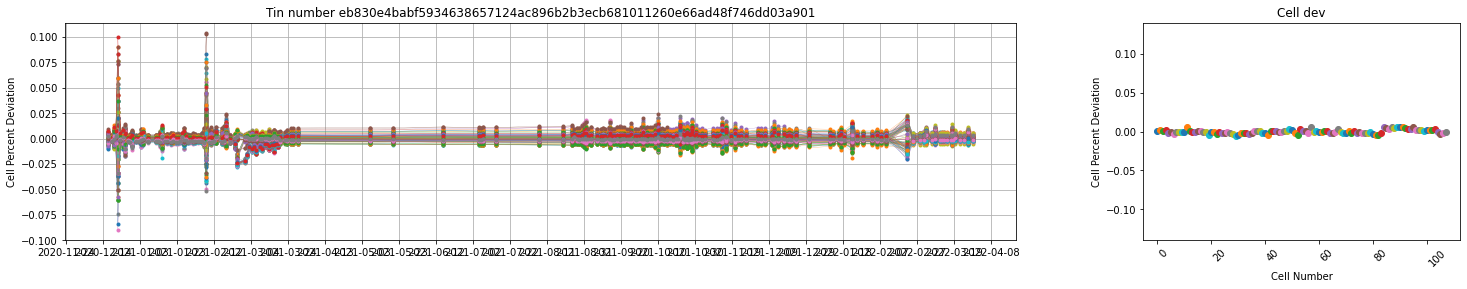

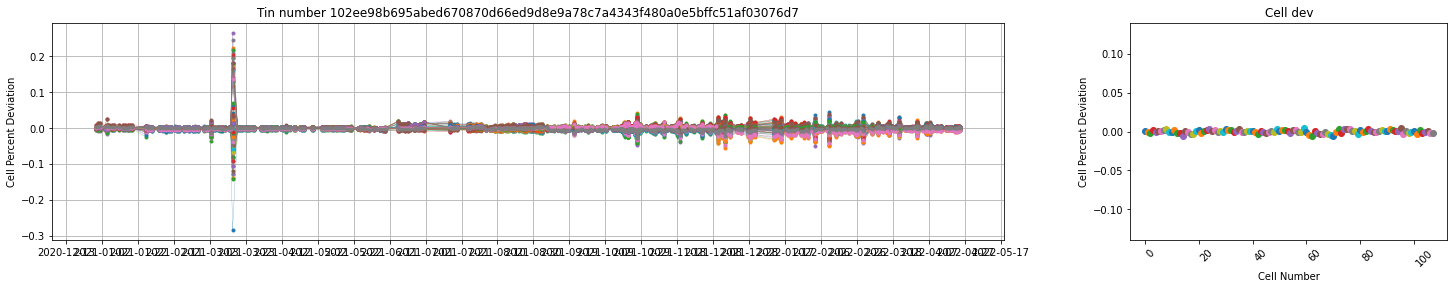

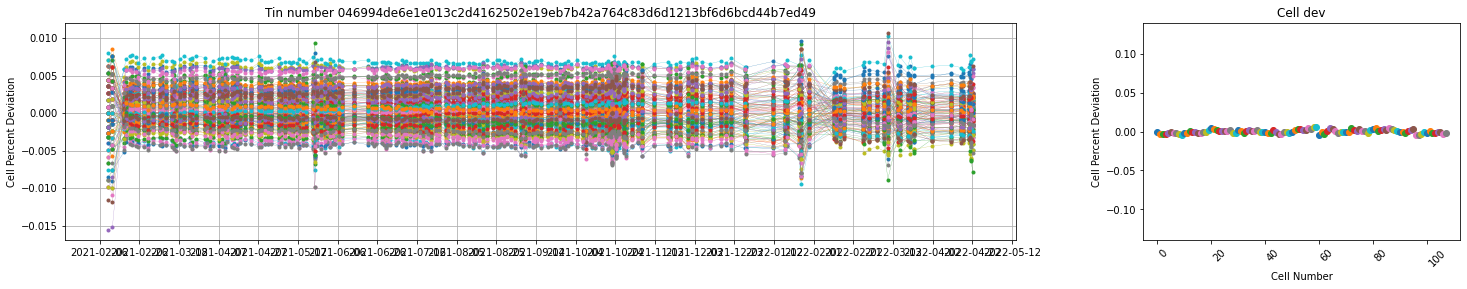

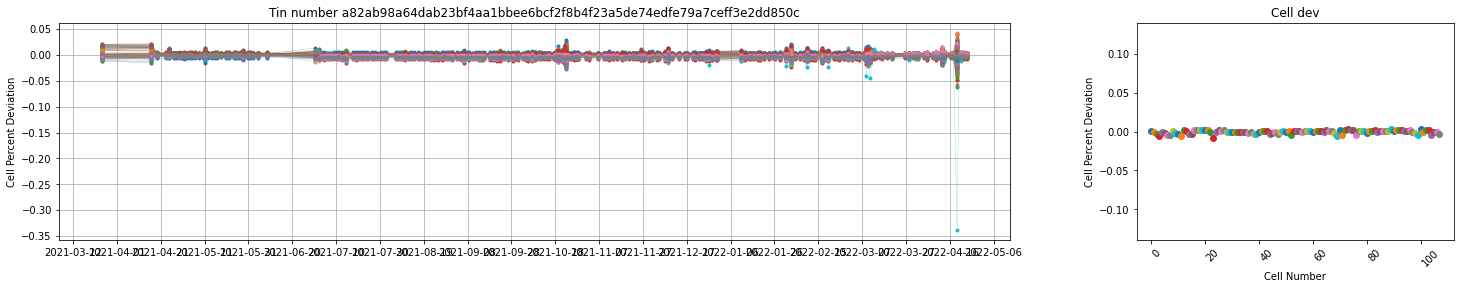

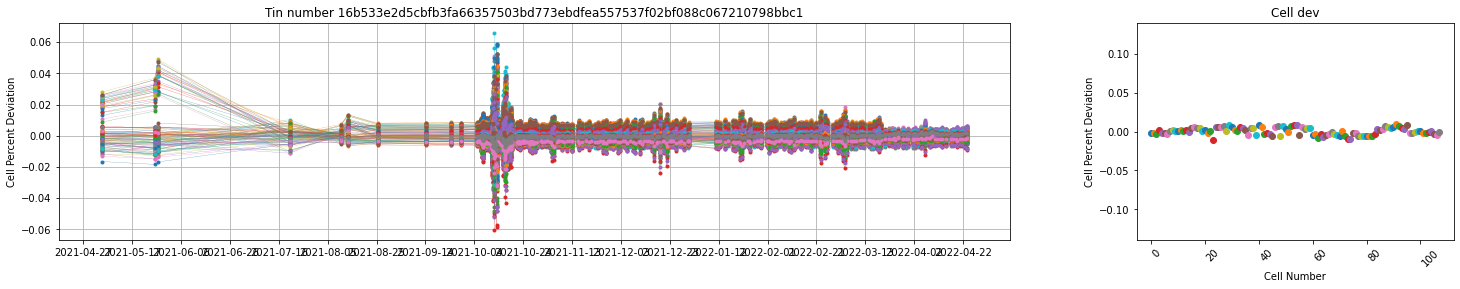

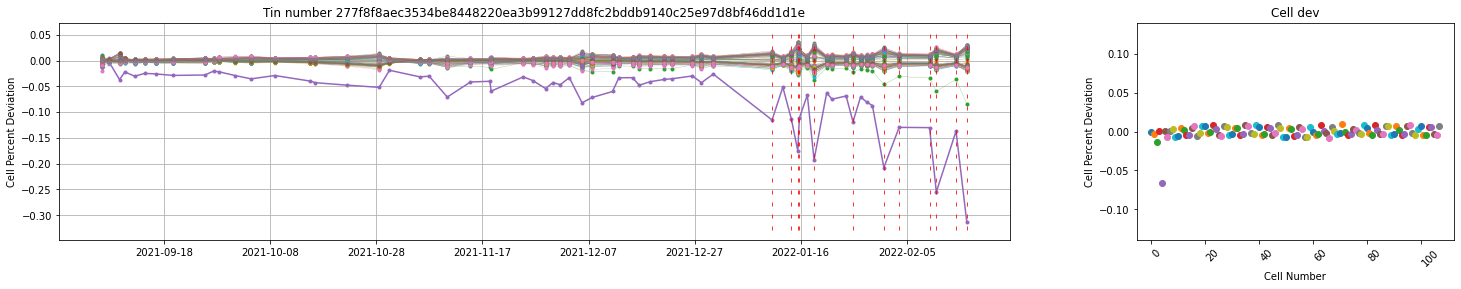

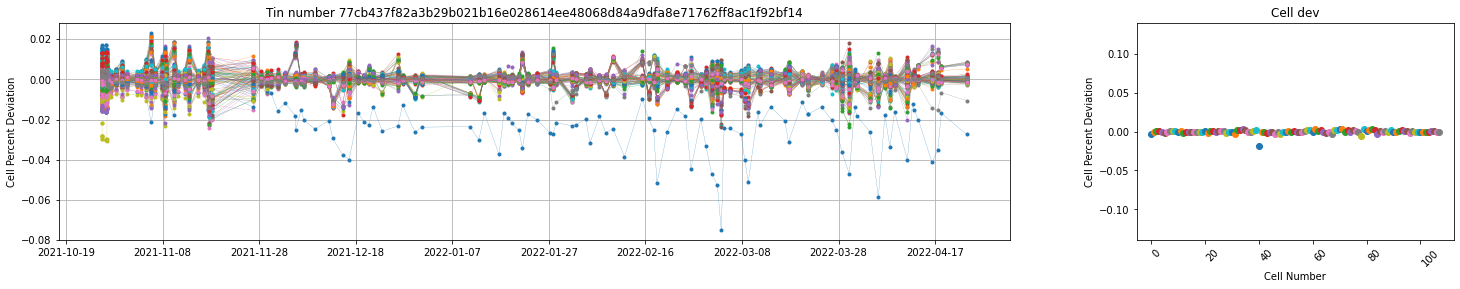

In [5]:
df_clean_last_SOC, df_tin_last, cars = plot_cells(df, show_legend=False, show_cells="all", method="Sorted_SOC_deviation")
#cars


In [1]:
cars

NameError: name 'cars' is not defined

In [14]:
# Om Fail  (Droppa alla Healthy)
df_clean_last_SOC.drop(healty_column_names(df_clean_last_SOC), axis=1,inplace=True)
df3 = df_clean_last_SOC
df3.head(2)

,Fail_cell_0,Fail_cell_1,Fail_cell_2,Fail_cell_3,Fail_cell_4,Fail_cell_5,Fail_cell_6,Fail_cell_7,Fail_cell_8,Fail_cell_9,...,Fail_cell_98,Fail_cell_99,Fail_cell_100,Fail_cell_101,Fail_cell_102,Fail_cell_103,Fail_cell_104,Fail_cell_105,Fail_cell_106,Fail_cell_107
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-11-27 09:56:48,-0.001724,-0.000539,0.000539,-0.001509,-0.001832,-0.001078,-0.000431,-0.000539,0.000323,0.001293,...,0.001186,0.000108,-0.000323,0.000539,0.000862,0.000431,0.000539,0.000647,0.000216,0.000000
2020-11-28 10:10:59,-0.001557,-0.000566,0.001133,-0.001133,-0.001699,-0.000566,0.000283,0.000283,0.001416,0.002265,...,0.002407,0.001133,0.001274,0.001840,0.002407,0.001982,0.001840,0.002123,0.001699,0.001133


<AxesSubplot:xlabel='timestamp'>

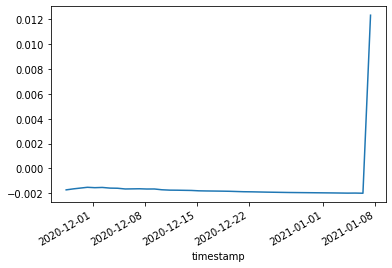

In [16]:
cell = "Fail_cell_0"
df3.expanding().mean()[cell].plot()